# Testing the constant-time case


## Import useful packages

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

## Define functions to load the data


In [ ]:
def load_image(image_path, dim=(224,224)):
  """
  Loads a single image as a Numpy array and resizes it as
  desired.  The default dimensions are consistent with
  those expected by the VGG models.  

  Args:
    image_path: str pointing to the file

    dim: Two-element tuple giving the desired height
         and width of the processed image

  Returns:
    image:  A single-channel Numpy array
    """
  image = cv2.imread(image_path, 0)
  image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
  return image

In [ ]:
def build_input(image_dir):
  """
  Loads all of the images into a single numpy array.
  Assumes that there are 101 equally-spaced images
  spanning lattitudes from 35N to 45N.  

  Args:
    image_dir: str giving name of the image directory

  Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.
    
    y:  A 1-dimensional numpy array of target lattitudes.
    """
  X = []
  files = os.listdir(image_dir)
  for file in files:
    if file[-4:] == '.png':
      image_path = os.path.join(image_dir, file)
      image = load_image(image_path)
      X.append(image)
  return (np.array(X) / 255)

In [ ]:
def build_labels(image_dir):
  files = os.listdir(image_dir)
  y = []
  for file in files:
    if file[-4:] == '.png':
      file_split = file.split('+')
      lat = float(file_split[0])
      long = float(file_split[1])
      y.append((lat, long))
  return np.array(y)

(224, 224)


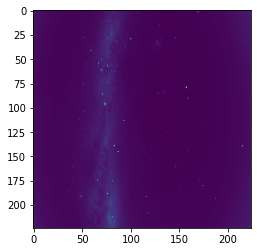

In [ ]:
sample_image = load_image('/content/36.03313909320676+-74.17584963505313+2020-05-25T00:59:02.png')
plt.imshow(sample_image)
print(sample_image.shape)

## Prepare the data

### Load the images

In [ ]:
X = build_input("/content")

In [ ]:
X.shape

(999, 224, 224)

In [ ]:
y = build_labels("/content")

In [ ]:
y.shape

(999, 2)


Standardize the values

In [ ]:
y[:,0] = scale(y[:,0])
y[:,1] = scale(y[:,1])

In [ ]:
print(y[:,0].mean(), y[:,0].std())
print(y[:,1].mean(), y[:,1].std())

2.3933696755082455e-15 0.9999999999999999
-6.526644423442061e-15 1.0


### Split into test and training sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(799, 224, 224)
(799, 2)
(200, 224, 224)
(200, 2)


## The model

We can probably prune this back a bit.  This is simply a DNN with single layer output suitable for regression.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2)
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               25690624  
_________________________________________________________________
dense_43 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_44 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_45 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_46 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_47 (Dense)             (None, 256)              

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

In [ ]:
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

`callbacks` can be used to tell the model when to stop training.  In this case, I'm having it stop if the mean squared error hasn't improved for 20 epochs.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=30)

Fit the model.

In [ ]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
                    verbose=2, epochs=1000, callbacks=[callback])

Epoch 1/1000
25/25 - 0s - loss: 0.9936 - mean_squared_error: 0.9936 - val_loss: 1.0255 - val_mean_squared_error: 1.0255
Epoch 2/1000
25/25 - 0s - loss: 0.9935 - mean_squared_error: 0.9935 - val_loss: 1.0255 - val_mean_squared_error: 1.0255
Epoch 3/1000
25/25 - 0s - loss: 0.9935 - mean_squared_error: 0.9935 - val_loss: 1.0255 - val_mean_squared_error: 1.0255
Epoch 4/1000
25/25 - 0s - loss: 0.9934 - mean_squared_error: 0.9934 - val_loss: 1.0254 - val_mean_squared_error: 1.0254
Epoch 5/1000
25/25 - 0s - loss: 0.9931 - mean_squared_error: 0.9931 - val_loss: 1.0248 - val_mean_squared_error: 1.0248
Epoch 6/1000
25/25 - 0s - loss: 0.9924 - mean_squared_error: 0.9924 - val_loss: 1.0248 - val_mean_squared_error: 1.0248
Epoch 7/1000
25/25 - 0s - loss: 0.9921 - mean_squared_error: 0.9921 - val_loss: 1.0245 - val_mean_squared_error: 1.0245
Epoch 8/1000
25/25 - 0s - loss: 0.9911 - mean_squared_error: 0.9911 - val_loss: 1.0223 - val_mean_squared_error: 1.0223
Epoch 9/1000
25/25 - 0s - loss: 0.9901 -

### Evaluate model performance

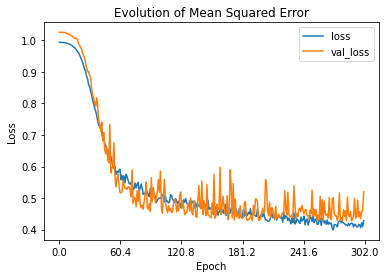

In [ ]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [ ]:
y_hat = model.predict(X_val)

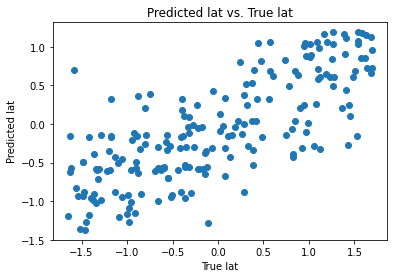

In [ ]:
plt.scatter(y_val[:,0], y_hat[:,0])
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()

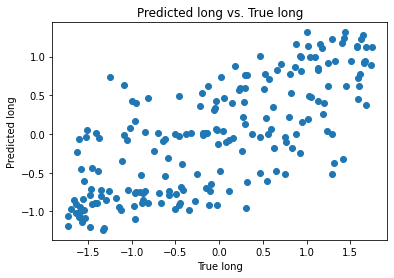

In [ ]:
plt.scatter(y_val[:,1], y_hat[:,1])
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
plt.show()